In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import time

/home/aschern/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def upsample_and_concat(x1, x2):
    x1 = tf.layers.conv2d_transpose(inputs=x1, filters=x1.shape[3] // 2, kernel_size=[2, 2], strides=2, padding="same")
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    offsets = [0, (x2_shape[1] - x1_shape[1]) // 2, (x2_shape[2] - x1_shape[2]) // 2, 0]
    size = [-1, x1_shape[1], x1_shape[2], -1]
    x2_crop = tf.slice(x2, offsets, size)
    x2_crop = tf.reshape(x2_crop, x1_shape)
    return tf.concat([x1, x2_crop], axis=3)

In [3]:
def pixel_wise_softmax(output_map):
    exponential_map = tf.exp(output_map)
    sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
    tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(output_map)[3]]))
    return tf.div(exponential_map,tensor_sum_exp)

In [4]:
def crop(x1, x2):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    offsets = [0, (x2_shape[1] - x1_shape[1]) // 2, (x2_shape[2] - x1_shape[2]) // 2]
    size = [-1, x1_shape[1], x1_shape[2]]
    x2_crop = tf.slice(x2, offsets, size)
    x2_crop = tf.reshape(x2_crop, x1_shape)
    return x2_crop

In [5]:
def cnn_model_fn(features, params, reuse=None):
    features_root = params["features_root"]
    input_layer = features
    pad = params["pad"]
    is_training = params["training"]
    classes = params["classes"]
    scope='Unet'
    with tf.variable_scope(scope, reuse=reuse):
        filt1 = features_root
        conv1 = tf.layers.conv2d(inputs=input_layer, filters=filt1, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=is_training)
        conv1 = tf.layers.conv2d(inputs=conv1, filters=filt1, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=is_training)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        filt2 = 2 * features_root
        conv2 = tf.layers.conv2d(inputs=pool1, filters=filt2, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=is_training)
        conv2 = tf.layers.conv2d(inputs=conv2, filters=filt2, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=is_training)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        filt3 = 4 * features_root
        conv3 = tf.layers.conv2d(inputs=pool2, filters=filt3, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=is_training)
        conv3 = tf.layers.conv2d(inputs=conv3, filters=filt3, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=is_training)
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

        filt4 = 8 * features_root
        conv4 = tf.layers.conv2d(inputs=pool3, filters=filt4, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv4 = tf.layers.batch_normalization(inputs=conv4, training=is_training)
        conv4 = tf.layers.conv2d(inputs=conv4, filters=filt4, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv4 = tf.layers.batch_normalization(inputs=conv4, training=is_training)
        pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)

        filt5 = 16 * features_root
        conv5 = tf.layers.conv2d(inputs=pool4, filters=filt5, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv5 = tf.layers.batch_normalization(inputs=conv5, training=is_training)
        conv5 = tf.layers.conv2d(inputs=conv5, filters=filt5, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv5 = tf.layers.batch_normalization(inputs=conv5, training=is_training)

        up6 = upsample_and_concat(conv5, conv4)
        conv6 = tf.layers.conv2d(inputs=up6, filters=filt4, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv6 = tf.layers.batch_normalization(inputs=conv6, training=is_training)
        conv6 = tf.layers.conv2d(inputs=conv6, filters=filt4, kernel_size=[3, 3],padding=pad, activation=tf.nn.relu)
        conv6 = tf.layers.batch_normalization(inputs=conv6, training=is_training)

        up7 = upsample_and_concat(conv6, conv3)
        conv7 = tf.layers.conv2d(inputs=up7, filters=filt3, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv7 = tf.layers.batch_normalization(inputs=conv7, training=is_training)
        conv7 = tf.layers.conv2d(inputs=conv7, filters=filt3, kernel_size=[3, 3],padding=pad, activation=tf.nn.relu)
        conv7 = tf.layers.batch_normalization(inputs=conv7, training=is_training)

        up8 = upsample_and_concat(conv7, conv2)
        conv8 = tf.layers.conv2d(inputs=up8, filters=filt2, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv8 = tf.layers.batch_normalization(inputs=conv8, training=is_training)
        conv8 = tf.layers.conv2d(inputs=conv8, filters=filt2, kernel_size=[3, 3],padding=pad, activation=tf.nn.relu)
        conv8 = tf.layers.batch_normalization(inputs=conv8, training=is_training)

        up9 = upsample_and_concat(conv8, conv1)
        conv9 = tf.layers.conv2d(inputs=up9, filters=filt1, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv9 = tf.layers.batch_normalization(inputs=conv9, training=is_training)
        conv9 = tf.layers.conv2d(inputs=conv9, filters=filt1, kernel_size=[3, 3], padding=pad, activation=tf.nn.relu)
        conv9 = tf.layers.batch_normalization(inputs=conv9, training=is_training)

        logits = tf.layers.conv2d(conv9, filters=classes, kernel_size=[1, 1], activation=tf.nn.relu)
        return logits

In [6]:
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

def fCRF(probabilities_batch, images, parametrs):
    ans = []
    for i in range(probabilities_batch.shape[0]):
        probabilities = probabilities_batch[i]
        d = dcrf.DenseCRF2D(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_LABELS)
        U = probabilities.transpose(2, 0, 1).reshape(NUM_LABELS, -1)
        unary = unary_from_softmax(U)
        unary = unary.copy(order='C')
        d.setUnaryEnergy(unary)
        compat1, compat2, w11, w12, w2 = parametrs
        d.addPairwiseGaussian(sxy=w2, compat=compat1)
        d.addPairwiseBilateral(sxy=w11, srgb=w12, rgbim=images[i], compat=compat2)
        Q = d.inference(5)
        res = np.argmax(Q, axis=0).reshape((images[i].shape[0], images[i].shape[1]))
        ans += [res]
    return ans

In [7]:
IMAGE_WIDTH = 448
IMAGE_HEIGHT = 224
NUM_CHANNELS = 3
NUM_LABELS = 30
BATCH_SIZE = 2
NUM_EPOCHS = 5
EVAL_BATCH_SIZE = 2
EVAL_FREQUENCY = 10
LEARNING_RATE = 0.001

In [8]:
train_data_node = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH))
eval_data = tf.placeholder(tf.float32, shape=(EVAL_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
eval_labels_node = tf.placeholder(tf.int64, shape=(EVAL_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH))
cnn_logits_node = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_LABELS))
batch = tf.Variable(0, dtype=tf.int64)

In [9]:
IS_TRAINING = True
FEATURE_ROOT = 32
PADDING = "same"
model_params = {"training": IS_TRAINING, "features_root": FEATURE_ROOT, "classes": NUM_LABELS, "pad": PADDING}

In [10]:
logits = cnn_model_fn(train_data_node, model_params, reuse=False)

train_prediction = tf.argmax(pixel_wise_softmax(logits), 3)
labels = crop(train_prediction, train_labels_node)
labels_ohe = tf.one_hot(labels, NUM_LABELS, axis=-1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_ohe))
#global_step = tf.train.get_or_create_global_step()
#learning_rate = tf.train.exponential_decay(learning_rate = LEARNING_RATE, global_step = global_step, decay_steps = 100, decay_rate = 0.97, staircase = True)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss, global_step=global_step)
learning_rate = LEARNING_RATE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss, global_step=batch)

eval_logits = cnn_model_fn(eval_data, model_params, reuse=True)
eval_prediction = tf.argmax(pixel_wise_softmax(eval_logits), 3)
eval_labels = crop(eval_prediction, eval_labels_node)
eval_labels_ohe = tf.one_hot(eval_labels, NUM_LABELS, axis=-1)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [11]:
from sklearn.metrics import jaccard_similarity_score


def accuracy_rate(predictions, labels):
    return 100.0 * np.sum(predictions == np.argmax(labels, 3)) / predictions.size

In [12]:
from skimage.io import imread, imshow
from scipy.misc import imresize


def read_data(path, train=True):
    batch_data = np.array([])
    batch_labels = np.array([])
    for img_name in path:
        img = imresize(imread(img_name), (IMAGE_HEIGHT, IMAGE_WIDTH))
        if batch_data.shape[0] == 0:
            batch_data = np.array([img])
        else:
            batch_data = np.append(batch_data, [img], axis=0)
        if train == True:
            file = img_name.replace('leftImg8bit', 'gtFine')[:-4] + '_labelIds.png'
            lab = imresize(imread(file), (IMAGE_HEIGHT, IMAGE_WIDTH), interp='nearest')
            if batch_labels.shape[0] == 0:
                batch_labels = np.array([lab])
            else:
                batch_labels = np.append(batch_labels, [lab], axis=0)
    return batch_data, batch_labels

In [13]:
labels_to_rgb = {
    0: (0, 0, 0),
    1: (0, 0, 0),
    2: (0, 0, 0),
    3: (0, 0, 0),
    4: (0, 0, 0),
    5: (111, 74, 0),
    6: (81, 0, 81),
    7: (128, 64, 128),
    8: (244, 35, 232),
    9: (250, 170, 160),
    10: (230, 150, 140),
    11: (70, 70, 70),
    12: (102, 102, 156),
    13: (190, 153, 153),
    14: (180, 165, 180),
    15: (150, 100, 100),
    16: (150, 120, 90),
    17: (153, 153, 153),
    18: (153, 153, 153),
    19: (250, 170, 30),
    20: (220, 220, 0),
    21: (107, 142, 35),
    22: (152, 251, 152),
    23: (70, 130, 180),
    24: (220, 20, 60),
    25: (255, 0, 0),
    26: (0, 0, 142),
    27: (0, 0, 70),
    28: (0, 60, 100),
    29: (0, 0, 90),
    30: (0, 0, 110),
    31: (0, 80, 100),
    32: (0, 0, 230),
    33: (119, 11, 32),
    -1: (0, 0, 142),
}

In [14]:
def img_to_rgb(img):
    image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for i in range(34):
        image[img == i] = labels_to_rgb[i]
    return image

In [15]:
def eval_in_batches(path, sess, evaluate=True):
    """Get all predictions for a dataset by running it in small batches."""
    size = len(path)
    accuracy = 0
    jac = 0
    for begin in range(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            batch_data, batch_labels = read_data(path[begin:end], train=evaluate)
        else:
            batch_data, batch_labels = read_data(path[begin:], train=evaluate)
        feed_dict={eval_data: batch_data, eval_labels_node: batch_labels}
        if evaluate:
            batch_result, labels = sess.run([eval_prediction, eval_labels_ohe], feed_dict=feed_dict)
            accuracy += accuracy_rate(batch_result, labels) * batch_data.shape[0]
            lab = np.argmax(labels, 3)
            jac += jaccard_similarity_score(lab.flatten(), batch_result.flatten()) * batch_data.shape[0]
    return accuracy / size, jac / size * 100

In [24]:
import os

path_im = []
for path, dirs, files in os.walk('/home/aschern/project/datasets/sityscapes/leftImg8bit/train'):
    for f in files:
        path_im.append(os.path.join(path, f))
        
path_test_im = []
for path, dirs, files in os.walk('/home/aschern/project/datasets/sityscapes/leftImg8bit/test'):
    for f in files:
        path_test_im.append(os.path.join(path, f))
        
path_val_im = []
for path, dirs, files in os.walk('/home/aschern/project/datasets/sityscapes/leftImg8bit/val'):
    for f in files:
        path_val_im.append(os.path.join(path, f))

In [25]:
print(len(path_im), len(path_val_im))

2975 500


In [22]:
path_val_im = path_val_im[:100]
path_test_im = path_test_im[:10]

/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Step 0 (epoch 0.00), 1.4 s, lr = 0.0010
Minibatch loss: 3.190
Minibatch accuracy: 20.1%
Validation accuracy: 15.3%
predicted:


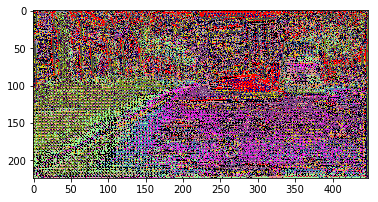

/home/aschern/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


correct:


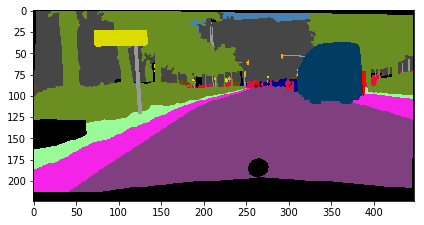

predicted:


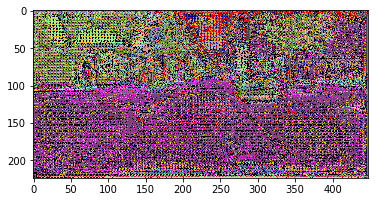

correct:


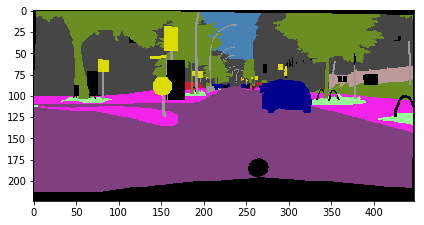

Model saved in file: ./unet_model_nc/unet-model_nc.ckpt
Step 10 (epoch 0.01), 8.5 s, lr = 0.0010
Minibatch loss: 2.201
Minibatch accuracy: 44.8%
Step 20 (epoch 0.01), 8.5 s, lr = 0.0010
Minibatch loss: 1.820
Minibatch accuracy: 53.4%
Step 30 (epoch 0.02), 8.5 s, lr = 0.0010
Minibatch loss: 1.450
Minibatch accuracy: 63.8%
Step 40 (epoch 0.03), 8.5 s, lr = 0.0010
Minibatch loss: 1.133
Minibatch accuracy: 70.6%
Step 50 (epoch 0.03), 8.5 s, lr = 0.0010
Minibatch loss: 1.321
Minibatch accuracy: 66.2%
Validation accuracy: 61.4%
predicted:


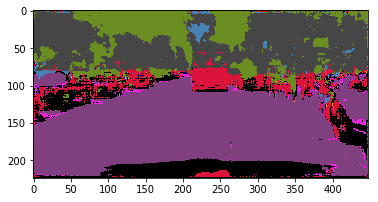

correct:


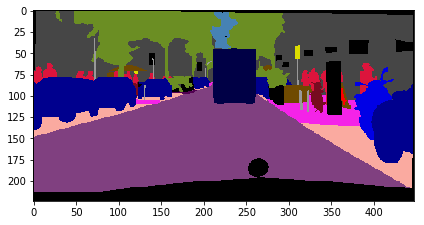

predicted:


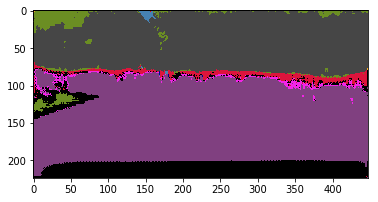

correct:


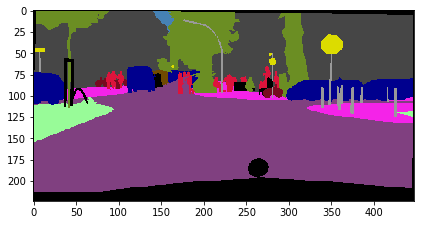

Step 60 (epoch 0.04), 8.5 s, lr = 0.0010
Minibatch loss: 1.303
Minibatch accuracy: 68.0%
Step 70 (epoch 0.05), 11.3 s, lr = 0.0010
Minibatch loss: 1.525
Minibatch accuracy: 63.2%
Step 80 (epoch 0.05), 9.8 s, lr = 0.0010
Minibatch loss: 1.178
Minibatch accuracy: 73.0%
Step 90 (epoch 0.06), 10.3 s, lr = 0.0010
Minibatch loss: 1.073
Minibatch accuracy: 71.3%
Step 100 (epoch 0.07), 9.4 s, lr = 0.0010
Minibatch loss: 1.074
Minibatch accuracy: 72.1%
Validation accuracy: 67.4%
predicted:


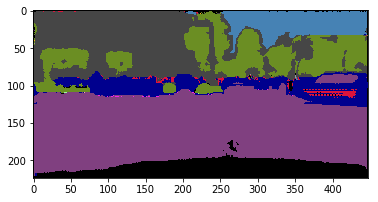

correct:


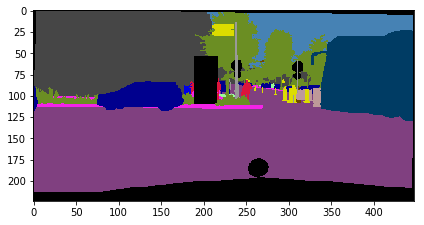

predicted:


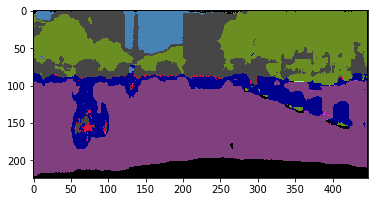

correct:


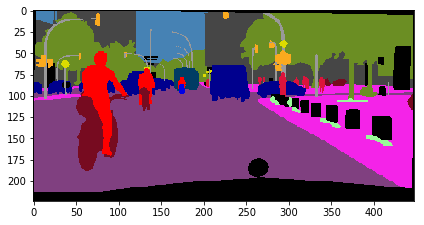

Step 110 (epoch 0.07), 9.9 s, lr = 0.0010
Minibatch loss: 1.161
Minibatch accuracy: 69.8%
Step 120 (epoch 0.08), 10.3 s, lr = 0.0010
Minibatch loss: 0.986
Minibatch accuracy: 74.2%
Step 130 (epoch 0.09), 10.0 s, lr = 0.0010
Minibatch loss: 1.008
Minibatch accuracy: 68.8%
Step 140 (epoch 0.09), 9.8 s, lr = 0.0010
Minibatch loss: 0.953
Minibatch accuracy: 73.4%
Step 150 (epoch 0.10), 10.0 s, lr = 0.0010
Minibatch loss: 0.802
Minibatch accuracy: 80.9%
Validation accuracy: 61.9%
predicted:


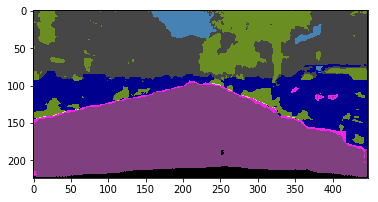

correct:


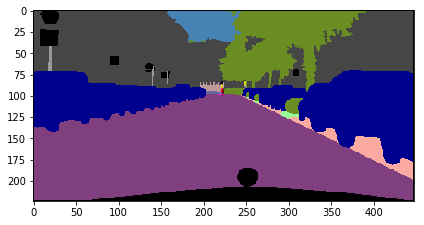

predicted:


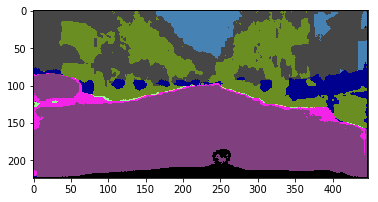

correct:


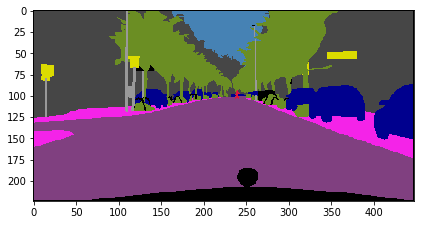

Step 160 (epoch 0.11), 9.1 s, lr = 0.0010
Minibatch loss: 0.773
Minibatch accuracy: 82.7%
Step 170 (epoch 0.11), 9.3 s, lr = 0.0010
Minibatch loss: 0.946
Minibatch accuracy: 71.0%
Step 180 (epoch 0.12), 9.2 s, lr = 0.0010
Minibatch loss: 0.853
Minibatch accuracy: 74.9%
Step 190 (epoch 0.13), 9.7 s, lr = 0.0010
Minibatch loss: 0.824
Minibatch accuracy: 78.8%
Step 200 (epoch 0.13), 9.4 s, lr = 0.0009
Minibatch loss: 0.673
Minibatch accuracy: 79.0%
Validation accuracy: 63.1%
predicted:


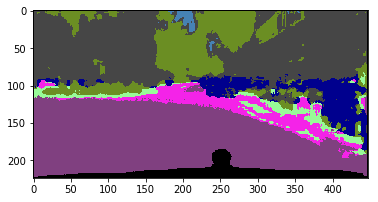

correct:


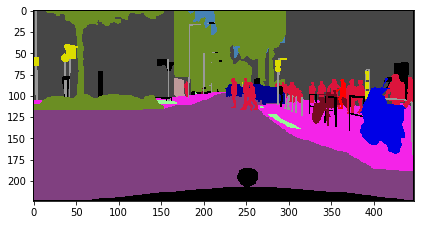

predicted:


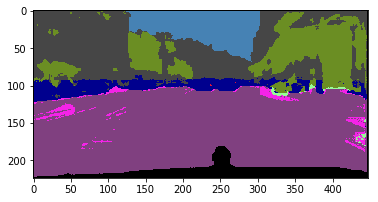

correct:


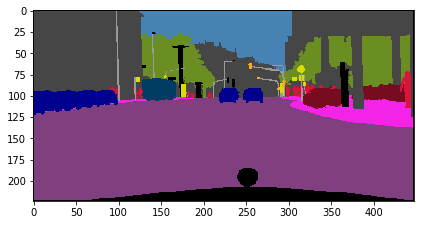

Step 210 (epoch 0.14), 9.8 s, lr = 0.0009
Minibatch loss: 0.572
Minibatch accuracy: 86.2%
Step 220 (epoch 0.15), 9.5 s, lr = 0.0009
Minibatch loss: 0.916
Minibatch accuracy: 75.9%
Step 230 (epoch 0.15), 9.0 s, lr = 0.0009
Minibatch loss: 0.897
Minibatch accuracy: 73.3%
Step 240 (epoch 0.16), 8.8 s, lr = 0.0009
Minibatch loss: 0.909
Minibatch accuracy: 76.2%
Step 250 (epoch 0.17), 8.8 s, lr = 0.0009
Minibatch loss: 0.953
Minibatch accuracy: 70.0%
Validation accuracy: 67.4%
predicted:


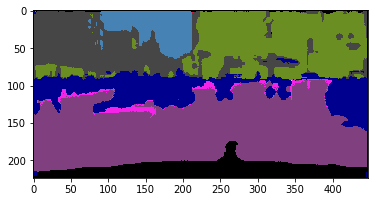

correct:


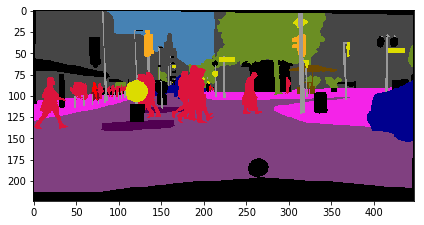

predicted:


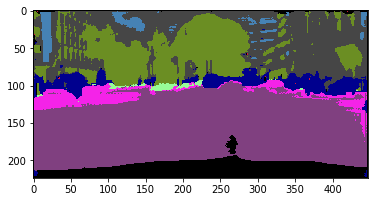

correct:


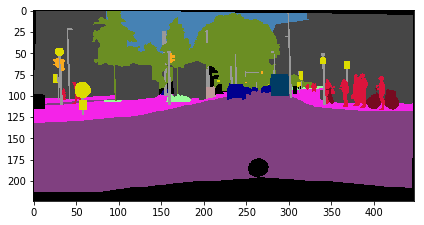

Step 260 (epoch 0.17), 9.2 s, lr = 0.0009
Minibatch loss: 0.627
Minibatch accuracy: 85.8%
Step 270 (epoch 0.18), 8.8 s, lr = 0.0009
Minibatch loss: 1.561
Minibatch accuracy: 53.7%
Step 280 (epoch 0.19), 9.2 s, lr = 0.0009
Minibatch loss: 1.220
Minibatch accuracy: 65.0%
Step 290 (epoch 0.19), 9.6 s, lr = 0.0009
Minibatch loss: 1.372
Minibatch accuracy: 62.7%
Step 300 (epoch 0.20), 9.2 s, lr = 0.0009
Minibatch loss: 0.934
Minibatch accuracy: 76.1%
Validation accuracy: 71.1%
predicted:


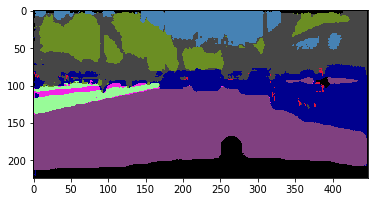

correct:


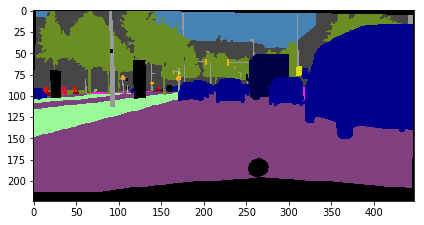

predicted:


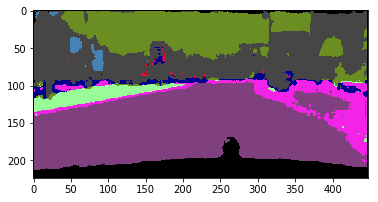

correct:


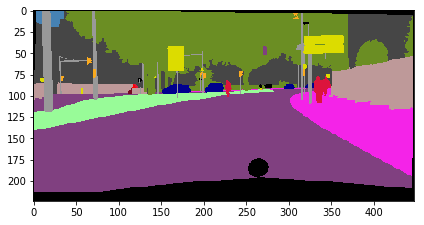

Model saved in file: ./unet_model_nc/unet-model_nc.ckpt
Step 310 (epoch 0.21), 9.4 s, lr = 0.0009
Minibatch loss: 0.967
Minibatch accuracy: 74.1%
Step 320 (epoch 0.22), 9.0 s, lr = 0.0009
Minibatch loss: 0.935
Minibatch accuracy: 68.6%
Step 330 (epoch 0.22), 9.4 s, lr = 0.0009
Minibatch loss: 0.939
Minibatch accuracy: 56.7%
Step 340 (epoch 0.23), 8.9 s, lr = 0.0009
Minibatch loss: 0.837
Minibatch accuracy: 76.1%
Step 350 (epoch 0.24), 10.0 s, lr = 0.0009
Minibatch loss: 0.691
Minibatch accuracy: 81.1%
Validation accuracy: 66.3%
predicted:


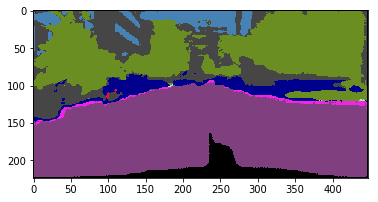

correct:


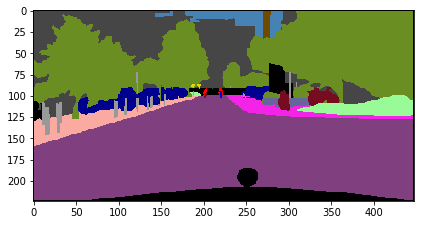

predicted:


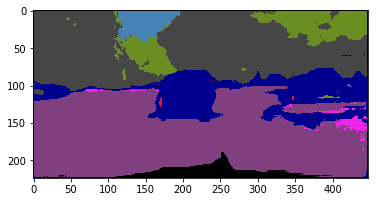

correct:


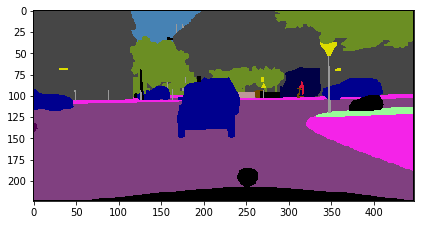

Step 360 (epoch 0.24), 9.2 s, lr = 0.0009
Minibatch loss: 0.950
Minibatch accuracy: 74.5%
Step 370 (epoch 0.25), 9.1 s, lr = 0.0009
Minibatch loss: 0.816
Minibatch accuracy: 76.0%
Step 380 (epoch 0.26), 8.9 s, lr = 0.0009
Minibatch loss: 1.079
Minibatch accuracy: 71.3%
Step 390 (epoch 0.26), 8.7 s, lr = 0.0009
Minibatch loss: 0.755
Minibatch accuracy: 78.9%
Step 400 (epoch 0.27), 10.2 s, lr = 0.0009
Minibatch loss: 0.926
Minibatch accuracy: 71.6%
Validation accuracy: 62.0%
predicted:


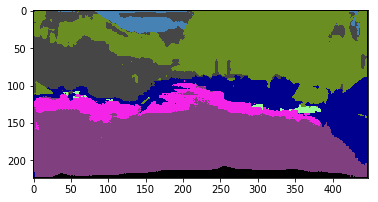

correct:


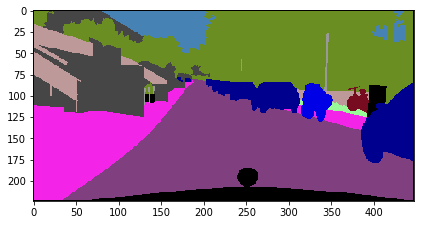

predicted:


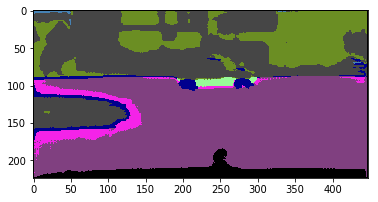

correct:


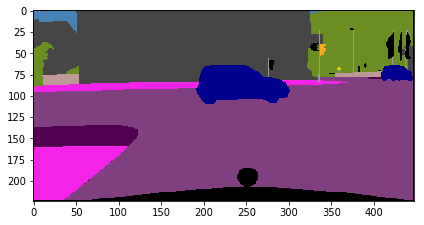

Step 410 (epoch 0.28), 9.0 s, lr = 0.0009
Minibatch loss: 0.732
Minibatch accuracy: 80.0%
Step 420 (epoch 0.28), 9.9 s, lr = 0.0009
Minibatch loss: 0.743
Minibatch accuracy: 80.7%
Step 430 (epoch 0.29), 8.9 s, lr = 0.0009
Minibatch loss: 0.865
Minibatch accuracy: 76.4%
Step 440 (epoch 0.30), 8.8 s, lr = 0.0009
Minibatch loss: 0.827
Minibatch accuracy: 79.2%
Step 450 (epoch 0.30), 9.0 s, lr = 0.0009
Minibatch loss: 0.948
Minibatch accuracy: 74.3%
Validation accuracy: 64.0%
predicted:


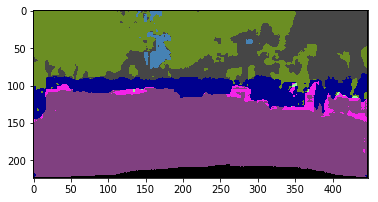

correct:


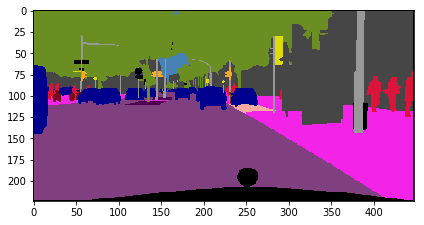

predicted:


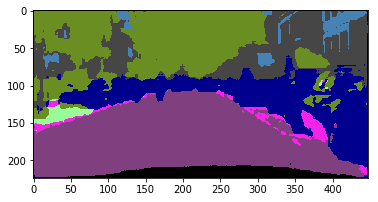

correct:


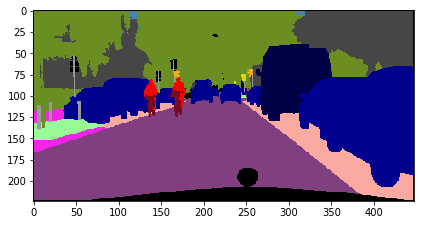

Step 460 (epoch 0.31), 9.4 s, lr = 0.0009
Minibatch loss: 0.986
Minibatch accuracy: 72.3%
Step 470 (epoch 0.32), 8.9 s, lr = 0.0009
Minibatch loss: 0.872
Minibatch accuracy: 79.3%
Step 480 (epoch 0.32), 9.6 s, lr = 0.0009
Minibatch loss: 0.989
Minibatch accuracy: 72.1%
Step 490 (epoch 0.33), 9.4 s, lr = 0.0009
Minibatch loss: 0.674
Minibatch accuracy: 81.1%
Step 500 (epoch 0.34), 9.4 s, lr = 0.0009
Minibatch loss: 0.862
Minibatch accuracy: 75.5%
Validation accuracy: 62.6%
predicted:


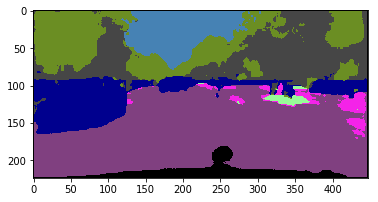

correct:


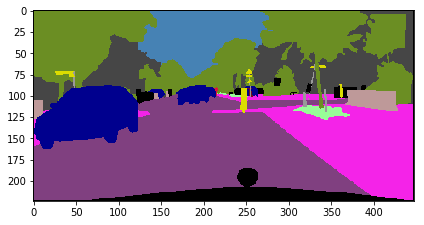

predicted:


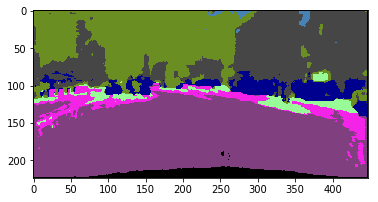

correct:


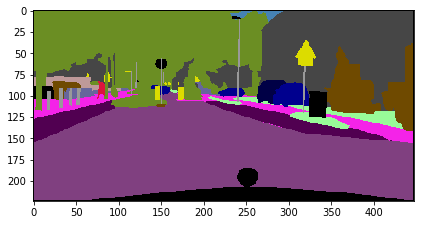

Step 510 (epoch 0.34), 10.0 s, lr = 0.0009
Minibatch loss: 1.134
Minibatch accuracy: 70.6%
Step 520 (epoch 0.35), 8.9 s, lr = 0.0009
Minibatch loss: 0.662
Minibatch accuracy: 79.9%
Step 530 (epoch 0.36), 9.4 s, lr = 0.0009
Minibatch loss: 0.751
Minibatch accuracy: 80.4%
Step 540 (epoch 0.36), 9.2 s, lr = 0.0009
Minibatch loss: 0.901
Minibatch accuracy: 69.1%
Step 550 (epoch 0.37), 9.5 s, lr = 0.0009
Minibatch loss: 0.682
Minibatch accuracy: 78.8%
Validation accuracy: 64.1%
predicted:


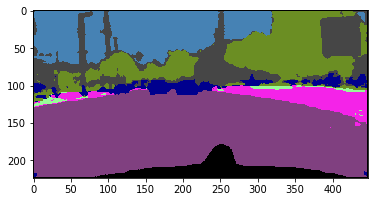

correct:


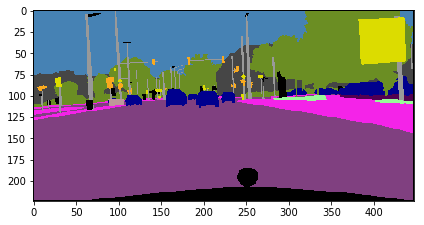

predicted:


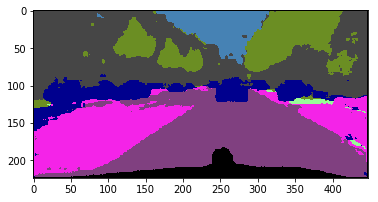

correct:


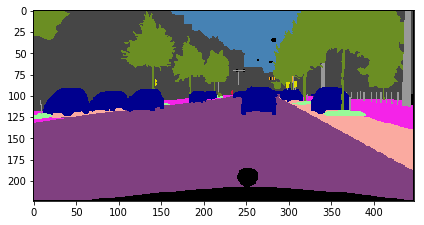

Step 560 (epoch 0.38), 9.0 s, lr = 0.0009
Minibatch loss: 0.675
Minibatch accuracy: 80.5%
Step 570 (epoch 0.38), 9.4 s, lr = 0.0009
Minibatch loss: 0.614
Minibatch accuracy: 81.8%
Step 580 (epoch 0.39), 9.1 s, lr = 0.0009
Minibatch loss: 1.147
Minibatch accuracy: 68.2%
Step 590 (epoch 0.40), 9.4 s, lr = 0.0009
Minibatch loss: 0.607
Minibatch accuracy: 83.7%
Step 600 (epoch 0.40), 11.6 s, lr = 0.0008
Minibatch loss: 1.019
Minibatch accuracy: 74.5%
Validation accuracy: 66.7%
predicted:


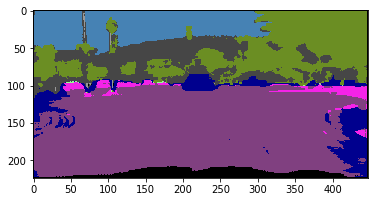

correct:


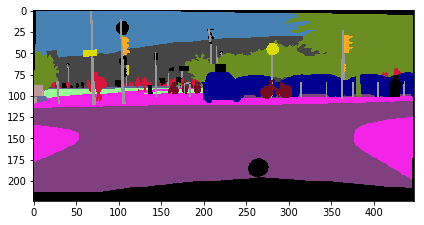

predicted:


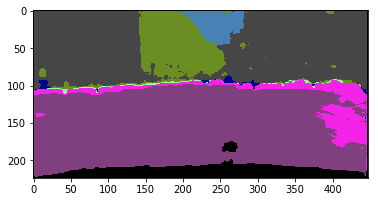

correct:


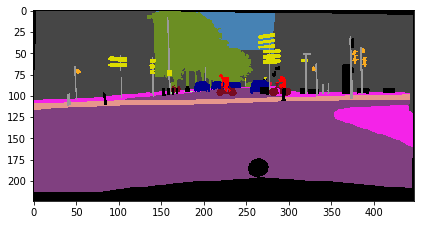

Model saved in file: ./unet_model_nc/unet-model_nc.ckpt
Step 610 (epoch 0.41), 10.5 s, lr = 0.0008
Minibatch loss: 0.844
Minibatch accuracy: 75.4%
Step 620 (epoch 0.42), 10.0 s, lr = 0.0008
Minibatch loss: 0.914
Minibatch accuracy: 73.5%


KeyboardInterrupt: 

In [20]:
import sys

model_path = "./unet_model_nc/unet-model_nc.ckpt"
saver = tf.train.Saver()
init = tf.global_variables_initializer()
train_size = len(path_im)
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    #load_path = saver.restore(sess, model_path)
    for step in range(int(NUM_EPOCHS * train_size) // BATCH_SIZE):
        offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
        batch_path = path_im[offset:offset + BATCH_SIZE]
        batch_data, batch_labels = read_data(batch_path)
        feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
        sess.run(optimizer, feed_dict=feed_dict)
        if step % EVAL_FREQUENCY == 0:
            l, lr, predictions, labels = sess.run([loss, learning_rate, train_prediction, labels_ohe], feed_dict=feed_dict)
            comp_time = time.time() - start_time
            print('Step %d (epoch %.2f), %.1f s, lr = %.4f' % (step, step * BATCH_SIZE / train_size, comp_time, lr))
            print('Minibatch loss: %.3f' % l)
            print('Minibatch accuracy: %.1f%%' % accuracy_rate(predictions, labels))
            sys.stdout.flush()
            if step %  (5 * EVAL_FREQUENCY) == 0:
                score, _ = eval_in_batches(path_val_im, sess)
                print('Validation accuracy: %.1f%%' % score)   
                for i in range(BATCH_SIZE):
                    plt.imshow(img_to_rgb(predictions[i]))
                    print("predicted:")
                    plt.show()
                    imshow(img_to_rgb(batch_labels[i]))
                    print("correct:")
                    plt.show()
                if step % (EVAL_FREQUENCY * 30) == 0:
                    saver.save(sess, model_path)
                    print("Model saved in file: %s" % model_path)
            start_time = time.time()
    saver.save(sess, model_path)
    print("Model saved in file: %s" % model_path)
    test_accuracy = eval_in_batches(path_test_im, sess)
    print('Test accuracy: %.1f%%' % test_accuracy)

In [22]:
import sys

model_path = "./unet_model/unet-model.ckpt"
saver = tf.train.Saver()
init = tf.global_variables_initializer()
train_size = len(path_val_im)
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    load_path = saver.restore(sess, model_path)
    print("Model restored from file: %s" % model_path)
    for step in range(int(train_size) // BATCH_SIZE):
        comp_time = time.time() - start_time
        offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
        batch_path = path_val_im[offset:offset + BATCH_SIZE]
        batch_data, batch_labels = read_data(batch_path)
        feed_dict = {eval_data: batch_data, eval_labels_node: batch_labels}
        proba, labels = sess.run([pixel_wise_softmax(eval_logits), eval_labels_ohe], feed_dict=feed_dict) 
        predictions = np.argmax(proba, 3)
        for compat1 in range(1, 16, 2):
            for compat2 in range(1, 16, 2):
                for w11 in range(1, 110, 15):
                    for w12 in range(1, 110, 15):
                        for w2 in range(1, 110, 15):
                            parametrs = (compat1, compat2, w11, w12, w2)
                            res = np.array(fCRF(proba, batch_data, parametrs))
                            ac1 = accuracy_rate(predictions, labels)
                            ac2 = accuracy_rate(res, labels)
                            if ac2 > ac1 + 0.5:
                                print(parametrs)
                                print('Minibatch accuracy: %.1f%%' % ac1)
                                print('Minibatch FCRF accuracy: %.1f%%' % ac2)
                                sys.stdout.flush()
        start_time = time.time()

INFO:tensorflow:Restoring parameters from ./unet_model/unet-model.ckpt
Model restored from file: ./unet_model/unet-model.ckpt


/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(1, 1, 1, 1, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 16, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 16, 31)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 31, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 31, 31)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 46, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 46, 31)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 61, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 76, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 91, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 106, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 1, 106, 31)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 16, 1, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.2%
(1, 1, 16, 1, 31)
Miniba

(1, 1, 61, 1, 91)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 61, 1, 106)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 61, 16, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 61, 16, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 61, 31, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 76, 1, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.3%
(1, 1, 76, 1, 31)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.2%
(1, 1, 76, 1, 46)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 76, 1, 61)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 76, 1, 76)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 76, 1, 91)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 76, 1, 106)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 76, 16, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(1, 1, 91, 1, 16)
Mi

(3, 1, 16, 46, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 1, 16, 61, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 1, 31, 16, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 1, 31, 31, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 1, 46, 16, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 3, 1, 1, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 3, 1, 16, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 3, 16, 1, 16)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 3, 16, 16, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.2%
(3, 3, 16, 31, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 3, 16, 46, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 3, 31, 1, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.2%
(3, 3, 31, 16, 1)
Minibatch accuracy: 83.6%
Minibatch FCRF accuracy: 84.1%
(3, 3, 46, 1, 1)
Minibatch 

KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from ./unet_model/unet-model.ckpt
Model restored from file: ./unet_model/unet-model.ckpt


/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(1, 3, 46, 1, 16)
Minibatch accuracy: 76.9%
Minibatch FCRF accuracy: 76.7%
(1, 3, 46, 1, 16)
Minibatch accuracy: 86.5%
Minibatch FCRF accuracy: 86.8%
(1, 3, 46, 1, 16)
Minibatch accuracy: 74.9%
Minibatch FCRF accuracy: 75.4%
(1, 3, 46, 1, 16)
Minibatch accuracy: 89.2%
Minibatch FCRF accuracy: 89.9%
(1, 3, 46, 1, 16)
Minibatch accuracy: 81.6%
Minibatch FCRF accuracy: 82.3%
(1, 3, 46, 1, 16)
Minibatch accuracy: 87.5%
Minibatch FCRF accuracy: 87.9%
(1, 3, 46, 1, 16)
Minibatch accuracy: 81.3%
Minibatch FCRF accuracy: 82.1%
42
predicted FCRF:


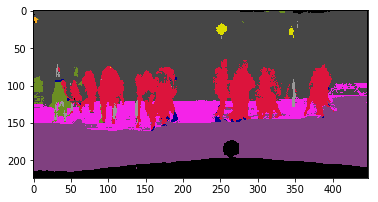

predicted U-net:


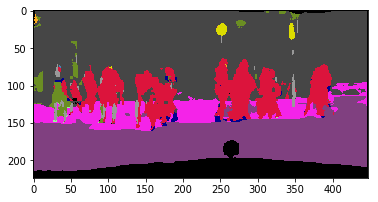

/home/aschern/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


correct:


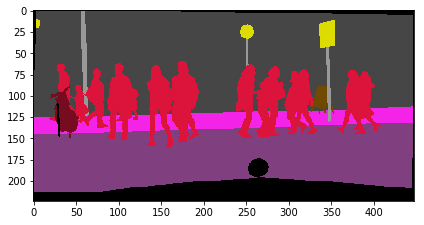

42
predicted FCRF:


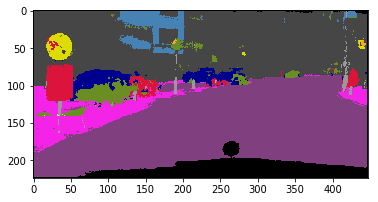

predicted U-net:


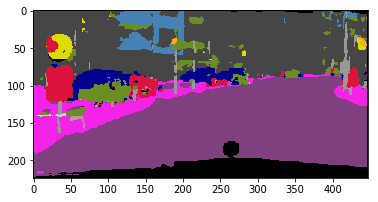

correct:


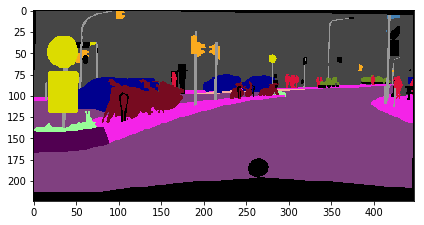

(1, 3, 46, 1, 16)
Minibatch accuracy: 77.2%
Minibatch FCRF accuracy: 76.6%
(1, 3, 46, 1, 16)
Minibatch accuracy: 78.2%
Minibatch FCRF accuracy: 80.3%
46
predicted FCRF:


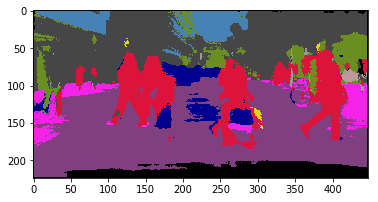

predicted U-net:


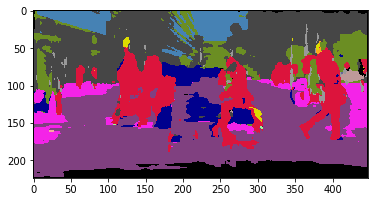

correct:


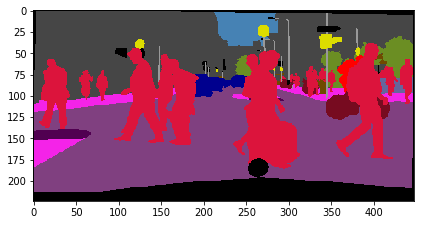

46
predicted FCRF:


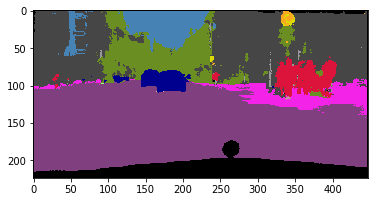

predicted U-net:


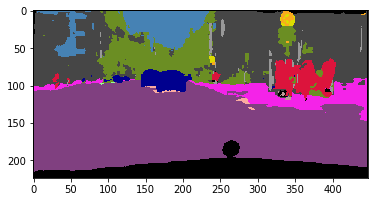

correct:


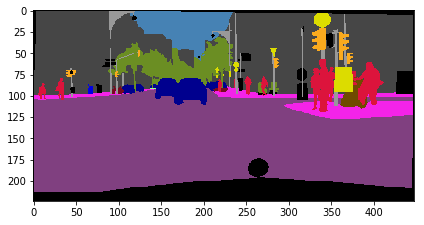

(1, 3, 46, 1, 16)
Minibatch accuracy: 82.9%
Minibatch FCRF accuracy: 81.8%
(1, 3, 46, 1, 16)
Minibatch accuracy: 77.0%
Minibatch FCRF accuracy: 77.3%


KeyboardInterrupt: 

In [19]:
import sys
from skimage.io import imsave


model_path = "./unet_model/unet-model.ckpt"
saver = tf.train.Saver()
init = tf.global_variables_initializer()
train_size = len(path_val_im)
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    load_path = saver.restore(sess, model_path)
    print("Model restored from file: %s" % model_path)
    for step in range(int(train_size) // BATCH_SIZE):
        comp_time = time.time() - start_time
        offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE) + 30
        batch_path = path_val_im[offset:offset + BATCH_SIZE]
        batch_data, batch_labels = read_data(batch_path)
        feed_dict = {eval_data: batch_data, eval_labels_node: batch_labels}
        proba, labels = sess.run([pixel_wise_softmax(eval_logits), eval_labels_ohe], feed_dict=feed_dict) 
        predictions = np.argmax(proba, 3)
        
        parametrs = (1, 3, 46, 1, 16)
        res = np.array(fCRF(proba, batch_data, parametrs))
        ac1 = accuracy_rate(predictions, labels)
        ac2 = accuracy_rate(res, labels)
        print(parametrs)
        print('Minibatch accuracy: %.1f%%' % ac1)
        print('Minibatch FCRF accuracy: %.1f%%' % ac2)
        sys.stdout.flush()
        if ac2 > ac1 + 0.8:
            for i in range(BATCH_SIZE):
                print(offset)
                imsave('unet-rnn-ans.png', img_to_rgb(res[i]))
                print("predicted FCRF:")
                plt.imshow(img_to_rgb(res[i]))
                plt.show()
                plt.imshow(img_to_rgb(predictions[i]))
                imsave('unet-ans.png', img_to_rgb(predictions[i]))
                print("predicted U-net:")
                plt.show()
                imshow(img_to_rgb(batch_labels[i]))
                imsave('gr_tr.png', img_to_rgb(batch_labels[i]))
                imsave('im.png', batch_data[i])
                print("correct:")
                plt.show()
        start_time = time.time()

In [53]:
import sys


model_path = "./unet_model/unet-model.ckpt"
saver = tf.train.Saver()
init = tf.global_variables_initializer()
path = path_val_im
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    load_path = saver.restore(sess, model_path)
    print("Model restored from file: %s" % model_path)
    size = len(path)
    score, jac = eval_in_batches(path, sess)
    print('Validation U-net IoU: %.2f%%' % jac)
    print('Validation U-net accuracy: %.2f%%' % score)
    accuracy = 0
    jac = 0
    for begin in range(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            batch_data, batch_labels = read_data(path[begin:end])
        else:
            batch_data, batch_labels = read_data(path[begin:])
        feed_dict={eval_data: batch_data, eval_labels_node: batch_labels}
        proba, labels = sess.run([pixel_wise_softmax(eval_logits), eval_labels_ohe], feed_dict=feed_dict)
        parametrs = (1, 3, 46, 1, 16)
        res = np.array(fCRF(proba, batch_data, parametrs))
        accuracy += accuracy_rate(res, labels) * batch_data.shape[0]
        jac += jaccard_similarity_score(np.argmax(labels, 3).flatten(), res.flatten()) * batch_data.shape[0]
    score = accuracy / size
    jac /= size
    print('Validation FCRF IoU: %.2f%%' % (jac * 100))
    print('Validation FCRF accuracy: %.2f%%' % score)

INFO:tensorflow:Restoring parameters from ./unet_model/unet-model.ckpt
Model restored from file: ./unet_model/unet-model.ckpt


/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/aschern/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Validation U-net IoU: 84.57%
Validation U-net accuracy: 84.57%
Validation FCRF IoU: 84.79%
Validation FCRF accuracy: 84.79%
